# Loading Data

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [ ]:
runs = pd.read_csv("../input/hkracing/runs.csv")
runs.head()

In [ ]:
races = pd.read_csv('../input/hkracing/races.csv')
races.head()

# Select features and data cleaning

In [ ]:
runs_data = runs[['race_id', 'won', 'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw', 'win_odds',
       'place_odds', 'horse_id']]
runs_data.head()

In [ ]:
runs_data.shape

In [ ]:
races_data = races[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class', 'date']]
races_data.head()

In [ ]:
races_data.shape

In [ ]:
# merge the two datasets based on race_id column
df = pd.merge(runs_data, races_data)
df.head()

In [ ]:
df.shape

In [ ]:
# Display the columns that have the most missing values
df.isnull().sum().sort_values(ascending=False)

The amount of rows for missing values is relatively small, therefore we decided to drop these rows.

In [ ]:
df = df.dropna()
df.shape

In [ ]:
df.date = pd.to_datetime(df.date)

In [ ]:
# Basic information about the dataset
start_time = min(df.date).strftime('%d %B %Y')
end_time = max(df.date).strftime('%d %B %Y')
no_of_horses = df.horse_id.nunique()
no_of_races = df.race_id.nunique()

print("\033[1m" +f'The dataset was collected from {start_time} to {end_time}, which contains information about {no_of_horses} horses and {no_of_races} races.'+ "\033[0m")

# Basic descriptive statistics by winning category

👇 Let’s do a quick basic descriptive summary statistics on some of the numeric attributes

In [ ]:
subset_attributes = ['horse_age','horse_rating', 'declared_weight',
                     'actual_weight','draw', 'win_odds', 'place_odds',
                     'surface', 'distance', 'race_class']


Winners = round(df[df['won']==1][subset_attributes].describe(),2)
Not_Winners = round(df[df['won']==0][subset_attributes].describe(),2)

pd.concat([Winners, Not_Winners], axis=1, keys=['Winners', 'Not Winners'])

**Comment** : The win odds and place odds will be for sure the main explicative features to predict the winner

# Visualisation

In [ ]:
# Creation of figure with 2 axis
sns.set(style="ticks")
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Creation of 1st axis
sns.boxplot(x="won", y="win_odds", data=df,ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title("Win odds distribution for non-winners and winners", fontsize=14)

# Creation of 2nd axis
sns.boxplot(x="won", y="place_odds", data=df,ax=ax[1])
ax[1].set_title("Place odds boxplot for non-winners and winners", fontsize=14)
ax[1].set(ylim=(0, 40))

# Close the empty Figure 2 created by seaborn.
plt.close(2)

In [ ]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(15, 10))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Horses Correlation Heatmap', fontsize=14)

The gradients in the heatmap vary based on the strength of the correlation and you can clearly see it is very easy to spot potential attributes having strong correlations amongst themselves.

# Model

## Preprocessing

First, we will apply some preprocessing methods like standardization or encoding

### categorical features

In [ ]:
features_categorical = ['horse_country', 'horse_type',
                       'horse_gear','venue', 'config','going','surface','race_class']

In [ ]:
def preprocess_categorical_features(X):   
    ''' Returns a new DataFrame with dummified columns'''
    df = X.copy()
    return pd.get_dummies(df.apply(lambda col: col.astype('category')))

In [ ]:
preprocess_categorical_features(df[features_categorical])

### numerical features

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
features_numerical = ['horse_age','horse_rating', 'declared_weight',
                     'actual_weight','draw', 'win_odds', 'place_odds', 'distance']

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler

def preprocess_numerical_features(X):
    '''
    Returns a new DataFrame with
    - Missing values replaced by Column Mean
    - Features Standard Scaled
    - Original Features names kept in the DataFrame
    '''
    df = X.copy()
    
    # Scale feature
    ct = ColumnTransformer([], remainder=StandardScaler())
    tmp = ct.fit_transform(df)
    # keep feature names
    for (col_index, col_name) in enumerate(list(df.columns)):
        df[col_name] = tmp[:, col_index]
    return df

In [ ]:
preprocess_numerical_features(df[features_numerical])

### Concatenation of preprocess data

In [ ]:
data_preprocessed = pd.concat(
    [
        df[['won']],
        preprocess_numerical_features(df[features_numerical]),
        preprocess_categorical_features(df[features_categorical])
    ], axis=1)
data_preprocessed.shape

### Distribution of labels

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data_preprocessed, x='won')
plt.title('Number of Labels by Class')

## Split Dataset

Second, we split the data in two : a training set and a testing set.

In [ ]:
# Create a smaller dataset for investigation purpose only
sample_size = 10000
tmp = data_preprocessed.sample(sample_size, random_state=414)
X_small = tmp.drop(columns=['won'])
y_small = tmp['won']

In [ ]:
# Create X and y
X = data_preprocessed.drop(columns=['won'])
y = data_preprocessed['won']
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=414)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, random_state=414)

## Modeling

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

### Baseline and performance metrics

Here we can use the DummyClassifier to always predict “not win” as a baseline model as we know that there are much more "not winner" than "winner" in our dataset

In [ ]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

print(classification_report(y_test, dummy_pred))

We got an accuracy score of 92% without training a model. **Accuracy** is the ratio of correct predictions. 
 - A𝑐𝑐𝑢𝑟𝑎𝑐𝑦 = (𝑇𝑃+𝑇𝑁) / 𝑛

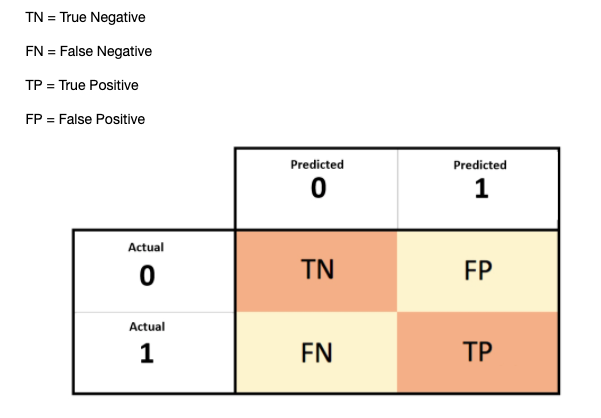

👇 Let’s compare this to logistic regression, an actual trained classifier.

In [ ]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print('Test score: ', accuracy_score(y_test, lr_pred))

Our accuracy score is the same as compared to the dummy classifier above. This tells us that accuracy might not be our best option for measuring performance.

In such an unbalanced problem, accuracy is meaningless: A very dumb model predicting always zeros would have great accuracy, to the detriment of the predictive power of class 1, which has **precision** and **recall** equal to zero!


- **Precision** measures the ability of a model to avoid false positives for a class. This is the number of true positives divided by all positive predictions.

 - P𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 𝑇𝑃 / 𝑇𝑃 + 𝐹𝑃
 
- **Recall** measures the ability of the model to detect occurences of a class. This is the number of true positives divided by the number of positive values in the test data.
 - R𝑒𝑐𝑎𝑙𝑙 = 𝑇𝑃 / 𝑇𝑃 + 𝐹𝑁

💡 **F1_score**, which is the weighted average of precision and recall, would be a good measure for this type of problem.

### Random Forest Classifier

We will try to train a Random Forest Classifier for our prediction. First, we will use the default hyperparameters

In [ ]:
%%time
# Simple Random Forest
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)

In [ ]:
%%time
y_pred = forest.predict(X_test)

In [ ]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
print(classification_report(y_test, y_pred))

**Precision** is now higher at 22% but overall we succeed to predict only 21 winners which is low.

**F1_score** improved slightly from our baseline score (48% --> 49%)

#### Hyperparameter tuning (on Random Forest Classifier)

In [ ]:
# First, we start with a wide RandomSearch because we have no idea

model = RandomForestClassifier(class_weight='balanced')

search_space = {'n_estimators': [int(x) for x in np.linspace(50, 1000, num=20)],
                'max_depth': [int(x) for x in np.linspace(10, 100, num=10)] + [None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
                }

cv_model = RandomizedSearchCV(model,
                              scoring='f1_macro',
                              param_distributions=search_space,
                              n_jobs=-1,
                              cv=2,
                              n_iter=30,
                              verbose=1)

In [ ]:
cv_model.fit(X_train, y_train)

In [ ]:
cv_model.best_estimator_

The best estimator is the following:
`RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_split=5, min_samples_leaf=1, n_estimators=800, criterion='gini', bootstrap=True)`

👇 Let's see the performance it gives

In [ ]:
y_pred = cv_model.predict(X_test)

In [ ]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
print(classification_report(y_test, y_pred))

Our performance improved a bit. **F1_score** improved slightly from 49% to 61%. 
We succeed to predict 627 _(=1529*41%)_ winners

## Forest-based most important features

We can use the Random Forest Classifier in order to find what are the most important features in our prediction

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced', max_depth=30, 
                                min_samples_split=5, min_samples_leaf=1, n_estimators=800, 
                                criterion='gini', bootstrap=True)
forest.fit(X_train, y_train)

In [ ]:
plt.plot(np.sort(forest.feature_importances_)[::-1])
plt.xlim(xmax=100, xmin=0)

In [ ]:
# Top 12 features
features_top_12 = pd.DataFrame(zip(forest.feature_importances_, list(X_train.columns))  
                              ).sort_values(by=0, ascending=False)[:12]
features_top_12.reset_index()

In [ ]:
features_top_12.reset_index(drop=True).rename(columns={0: 'Feature_importances', 1: "Top 12 features"})

**Conclusion:** We have run a model that allows us to predict correclty 871 winners.

We may have better results with other models (SGDClassifier, AdaBoost, KNNClassifier, etc.). 

We may also have better results with resampling techniques: Oversample minority class or Undersample majority class